# Assignment 2
02689 Advanced Numerical Methods for Differential Equations
- Jeppe Klitgaard <`s250250@dtu.dk`>
- Tymoteusz Barcinski <`s221937@dtu.dk`>
- Pernille Christie <`s204249@dtu.dk`>

In [22]:
import itertools
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from jk_utils import (
    construct_vandermonde,
    grad_jacobi_polynomial_normalised,
    jacobi_gauss_lobatto,
    jacobi_polynomial_normalised,
    jacobi_polynomial,
    grad_jacobi_polynomial,
    trigonometric_polynomial_centered,
)
from utils import JacobiGL, constructD, JacobiP
from common import setup_plotting, PAPER_WIDTH_IN, OUTPUT_DIR, EXPORT_DPI
from dataclasses import asdict, dataclass
from typing import Any
from typing_extensions import Self
from scipy.integrate import solve_ivp, trapezoid
import time

In [23]:
setup_plotting()

## 1 - Boundary Value Problems

### a) Tau vs Collocation

In [24]:
eps_vec = [0.001, 0.01, 0.1]

x0, xN = 0, 1
g0, gN = 0, 0

# Let z be Jacobi domain, z ∈ [-1, 1]
a, b = 0.0, 1.0  # Domain

def uexact(x, eps):
    return (np.exp(-x/eps) + (x-1) - np.exp(-1/eps)*x) / (np.exp(-1/eps) - 1)

def f(x):
    return np.ones(x.shape[0])

#### Tau

In [25]:
def Tau_Legendre(a, b, c, g0, gN, N):
    alpha, beta = 0, 0  # Legendre

    # Find Gauss Lobatto nodes
    z = JacobiGL(alpha, beta, N)

    ##### Find fhat values #####
    # Quadrature weights
    w = 2 / (N * (N+1)) / np.power(JacobiP(z, alpha, beta, N), 2)

    f_samples = np.ones_like(z)

    # Precompute Jacobi polynomials for all k=0..N-1
    # Shape: (N, len(x))
    Phi = np.vstack([JacobiP(z, alpha, beta, k) for k in range(N)])

    # Compute gamma_k for all k at once
    gamma = np.sum(Phi**2 * w, axis=1)

    # Compute numerator = <u, phi_k> for all k
    numerators = np.sum((f_samples * Phi) * w, axis=1)

    fhat = numerators / gamma

    ##### Calculate ghat #####
    nvec = np.arange(2, N-2)
    ghat = np.zeros_like(fhat, dtype = float)
    ghat[2:-2] = - fhat[:-4] / (a * (2*nvec - 3) * (2*nvec - 1)) \
                + fhat[2:-2] / (a * (2*nvec - 1) * (2*nvec + 3)) \
                - fhat[4:] / (a * (2*nvec + 1) * (2*nvec + 5))
    ghat[0:2] = fhat[0:2]
    ghat[-2] = g0
    ghat[-1] = gN

    ##### Set up system matrix A, such that A uhat = ghat #####
    A = np.zeros((N,N), dtype=float)

    # Add diagonal
    A[2:N-2, 2:N-2] = -1 * np.eye(N-4) # np.diag(c/a * 1/(eps*(2*nvec-1)*(2*nvec+3) - 1))

    # Add sub and super diagonals
    # A += np.diag(np.concatenate((-c/(a*(2*nvec-1)*(2*nvec-3)), [0, 0])), k=-2)
    A += np.diag(np.concatenate(([0], -b/a / (2*nvec-1), [0, 0])), k=-1)
    A += np.diag(np.concatenate(([0, 0], b/a /(2*nvec+3), [0])), k=1)
    # A += np.diag(np.concatenate(([0, 0], - c/a /((2*nvec+3)*(2*nvec+5)))), k=2)

    # Add two first rows using truncated versions of the sum-formulations
    nvec = np.arange(N)

    A[0, 2::2] = a/2 * (nvec[2::2] * (nvec[2::2] + 1))
    A[0, 1::2] = b * np.ones_like(nvec[1::2], dtype=float)
    A[1, 3::2] = a * 3/2 * (nvec[3::2] * (nvec[3::2] + 1) - 2)
    A[1, 2::2] = b * 3 * np.ones_like(nvec[2::2], dtype=float)

    # Add last two rows using boundary conditions
    A[-2:] = np.vstack([JacobiP([-1,1], alpha, beta, n) for n in range(N)]).transpose()

    ##### Find uhat by solving system #####
    uhat = np.linalg.solve(A, ghat)

    return w, z, uhat

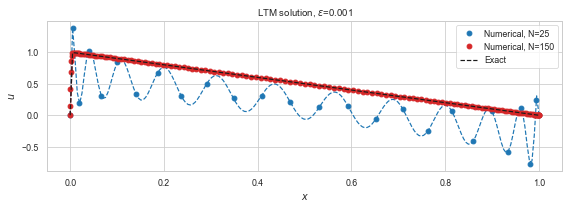

In [26]:
eps = 0.001

a_coeff, b_coeff, c_coeff = -4 * eps, -2, 0

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [25, 150]

colors = ['tab:blue', 'tab:red']

for (i,N) in enumerate(Ns):
    ##### Find uhat by solving system #####
    _, z, uhat = Tau_Legendre(a_coeff, b_coeff, c_coeff, g0, gN, N)

    Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
    x_eval = 1/2 * (z+1)

    u_compute = uhat @ Phi

    ##### Plot #####
    x_plot = np.linspace(x0, xN, 200, endpoint=True)
    z_plot = 2 * x_plot - 1
    Phi = np.vstack([JacobiP(z_plot, 0, 0, k) for k in range(N)])

    u_plot = uhat @ Phi

    ax.plot(x_eval, u_compute, "o", color=colors[i], label = f"Numerical, N={N}")
    ax.plot(x_plot, u_plot, "--", color=colors[i])

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LTM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_eps0001.png", dpi=EXPORT_DPI, bbox_inches='tight')

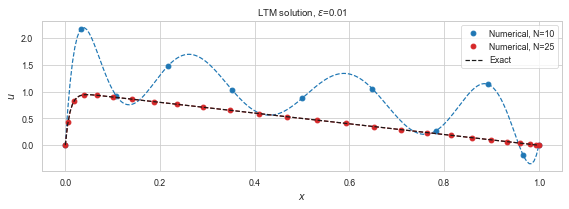

In [27]:
eps = 0.01

a_coeff = -4 * eps

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [10, 25]

colors = ['tab:blue', 'tab:red']

for (i,N) in enumerate(Ns):
    ##### Find uhat by solving system #####
    _, z, uhat = Tau_Legendre(a_coeff, b_coeff, c_coeff, g0, gN, N)

    Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
    x_eval = 1/2 * (z+1)

    u_compute = uhat @ Phi

    ##### Plot #####
    x_plot = np.linspace(x0, xN, 200, endpoint=True)
    z_plot = 2 * x_plot - 1
    Phi = np.vstack([JacobiP(z_plot, 0, 0, k) for k in range(N)])

    u_plot = uhat @ Phi

    ax.plot(x_eval, u_compute, "o", color=colors[i], label = f"Numerical, N={N}")
    ax.plot(x_plot, u_plot, "--", color=colors[i])

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LTM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_eps001.png", dpi=EXPORT_DPI, bbox_inches='tight')

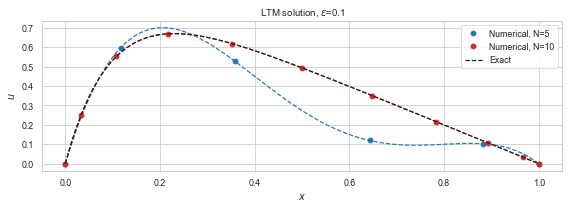

In [28]:
eps = 0.1

a_coeff = -4 * eps

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [5, 10]

colors = ['tab:blue', 'tab:red']

for (i,N) in enumerate(Ns):
    ##### Find uhat by solving system #####
    _, z, uhat = Tau_Legendre(a_coeff, b_coeff, c_coeff, g0, gN, N)

    Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
    x_eval = 1/2 * (z+1)

    u_compute = uhat @ Phi

    ##### Interpolation #####
    x_plot = np.linspace(x0, xN, 200, endpoint=True)
    z_plot = 2 * x_plot - 1
    Phi = np.vstack([JacobiP(z_plot, 0, 0, k) for k in range(N)])
    u_plot = uhat @ Phi

    ax.plot(x_eval, u_compute, "o", color=colors[i], label = f"Numerical, N={N}")
    ax.plot(x_plot, u_plot, "--", color=colors[i])

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LTM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_eps01.png", dpi=EXPORT_DPI, bbox_inches='tight')

In [29]:
##### Calculate errors #####
N_grids = np.arange(5, 200, 1, dtype=int)
errors = np.zeros((len(eps_vec), len(N_grids)), dtype=float)

jacobian = (b-a)/2.0

for (i, eps) in enumerate(eps_vec):
    a_coeff = - 4 * eps
    for (j, N) in enumerate(N_grids):
        w, z, uhat = Tau_Legendre(a_coeff, b_coeff, c_coeff, g0, gN, N)

        Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
        x_eval = 1/2 * (z+1)

        u_compute = uhat @ Phi

        u_ex = uexact(x_eval, eps)

        # errors[i, j] = np.linalg.norm(u_compute-u_ex) / np.linalg.norm(u_ex)

        error = u_compute - u_ex
        absolute_error = np.sqrt(np.sum((error ** 2) * jacobian * w))
        norm_true_solution = np.sqrt(np.sum((u_ex ** 2) * jacobian * w))
        errors[i, j] = absolute_error / norm_true_solution


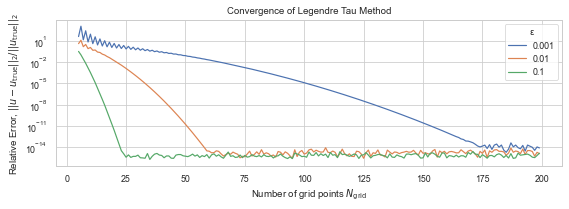

In [30]:
##### Plot error #####
fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

for (i, eps) in enumerate(eps_vec):
    ax.plot(N_grids, errors[i], "-", label=rf"{eps}")

ax.set_yscale('log')
ax.legend()
ax.set_title("Convergence of Legendre Tau Method")
ax.set_xlabel("Number of grid points $N_\\text{grid}$")
ax.set_ylabel("Relative Error, $||u - u_{\\mathrm{true}}||_2 / ||u_{\\mathrm{true}}||_2$")
sns.move_legend(ax, loc="best", title="ε")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_convergence.png", dpi=EXPORT_DPI, bbox_inches='tight')

#### Collocation

In [42]:
# Basis parameters
alpha = 0.0
beta = 0.0
basis_func = partial(jacobi_polynomial_normalised, alpha=alpha, beta=beta)
basic_func_grad = partial(grad_jacobi_polynomial_normalised, k=1, alpha=alpha, beta=beta)

def Collocation_legendre(N, epsilon):

    z_gl, w_gl = jacobi_gauss_lobatto(N, alpha, beta)  # Includes boundaries, domain: [-1, 1]
    # Uncomment to try equidistant grid
    # z_gl = np.linspace(-1, 1, N_grid)
    # w_gl = np.ones_like(z_gl) * 2.0 / (N_grid - 1)

    x_gl = 0.5 * (b - a) * (z_gl + 1) + a  # Map to [a, b]

    # Construct differentiation matrix
    V = construct_vandermonde(z_gl, N + 1, basis_func)
    V_z = construct_vandermonde(z_gl, N + 1, basic_func_grad)
    D_z = np.linalg.solve(
        V.T, V_z.T
    ).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

    A = -4.0 * epsilon * np.eye(N + 1)
    B = -2.0 * np.eye(N + 1)
    C = np.zeros((N + 1, N + 1))

    # Set up approximate operator
    L_N = D_z @ A @ D_z + B @ D_z + C

    # RHS
    F = np.ones(N + 1)

    # Enforce BCs
    L_N[0, :] = 0.0
    L_N[0, 0] = 1.0
    L_N[-1, :] = 0.0
    L_N[-1, -1] = 1.0
    F[0] = 0.0
    F[-1] = 0.0

    # Solve
    u_gl = np.linalg.solve(L_N, F)

    return x_gl, z_gl, u_gl, V

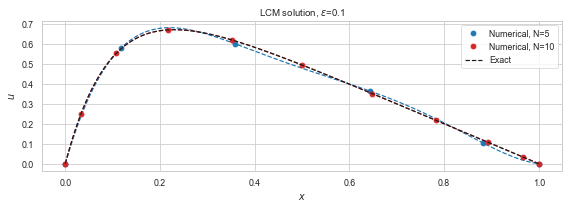

In [32]:
eps = 0.1

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [5, 10]

colors = ['tab:blue', 'tab:red']
for (i, N) in enumerate(Ns):
    x_gl, z_gl, u_gl, V = Collocation_legendre(N, eps)
    # Compute interpolated solution
    N_interp = 1000
    z_gl_interp = np.linspace(-1, 1, N_interp)
    x_gl_interp = 0.5 * (b - a) * (z_gl_interp + 1) + a  # Map to [a, b]
    V_interp = construct_vandermonde(z_gl_interp, N + 1, basis_func)
    I_n = np.linalg.solve(V.T, V_interp.T).T  # I_n = V_interp @ V^{-1}
    u_interp = I_n @ u_gl

    plt.plot(x_gl, u_gl, "o", color=colors[i], label=f"Numerical, N={N}")
    plt.plot(x_gl_interp, u_interp, "--", color=colors[i])
    plt.legend()

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LCM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_col_eps01.png", dpi=EXPORT_DPI, bbox_inches='tight')

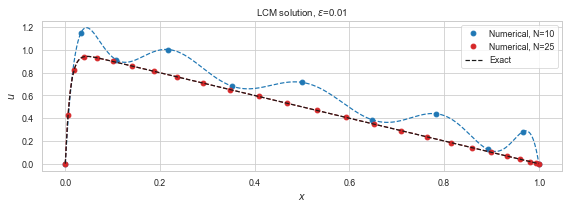

In [33]:
eps = 0.01

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [10, 25]

colors = ['tab:blue', 'tab:red']
for (i, N) in enumerate(Ns):
    x_gl, z_gl, u_gl, V = Collocation_legendre(N, eps)
    # Compute interpolated solution
    N_interp = 1000
    z_gl_interp = np.linspace(-1, 1, N_interp)
    x_gl_interp = 0.5 * (b - a) * (z_gl_interp + 1) + a  # Map to [a, b]
    V_interp = construct_vandermonde(z_gl_interp, N + 1, basis_func)
    I_n = np.linalg.solve(V.T, V_interp.T).T  # I_n = V_interp @ V^{-1}
    u_interp = I_n @ u_gl

    plt.plot(x_gl, u_gl, "o", color=colors[i], label=f"Numerical, N={N}")
    plt.plot(x_gl_interp, u_interp, "--", color=colors[i])
    plt.legend()

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LCM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_col_eps001.png", dpi=EXPORT_DPI, bbox_inches='tight')

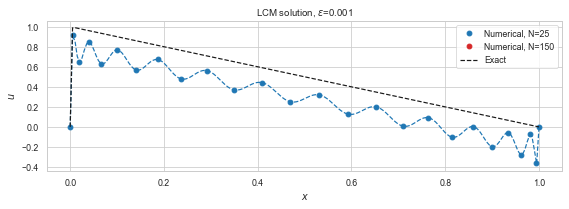

In [46]:
eps = 0.001

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [25, 150]

colors = ['tab:blue', 'tab:red']
for (i, N) in enumerate(Ns):
    x_gl, z_gl, u_gl, V = Collocation_legendre(N, eps)
    # Compute interpolated solution
    N_interp = 200
    z_gl_interp = np.linspace(-1, 1, N_interp)
    x_gl_interp = 0.5 * (b - a) * (z_gl_interp + 1) + a  # Map to [a, b]
    V_interp = construct_vandermonde(z_gl_interp, N + 1, basis_func)
    I_n = np.linalg.solve(V.T, V_interp.T).T  # I_n = V_interp @ V^{-1}
    u_interp = I_n @ u_gl

    ax.plot(x_gl, u_gl, "o", color=colors[i], label=f"Numerical, N={N}")
    ax.plot(x_gl_interp, u_interp, "--", color=colors[i])

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LCM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_col_eps0001.png", dpi=EXPORT_DPI, bbox_inches='tight')

In [9]:
# Basis parameters
alpha = 0.0
beta = 0.0

use_normalised = False
if use_normalised:
    basis_func = partial(jacobi_polynomial_normalised, alpha=alpha, beta=beta)
    basic_func_grad = partial(
        grad_jacobi_polynomial_normalised, k=1, alpha=alpha, beta=beta
    )
else:
    basis_func = partial(jacobi_polynomial, alpha=alpha, beta=beta)
    basic_func_grad = partial(
        grad_jacobi_polynomial, alpha=alpha, beta=beta
    )

def u_func_1(x, epsilon):
    denom = np.exp(-1.0 / epsilon) - 1
    nom = +np.exp(-x / epsilon) + (x - 1) - np.exp(-1 / epsilon) * x
    return nom / denom

epsilons = [0.1, 0.01, 0.001]
N_grids = np.arange(5, 200, 1, dtype=int)
data = []
for epsilon, N_grid in itertools.product(epsilons, N_grids):
    N = N_grid - 1  # Highest polynomial order

    z_gl, w_gl = jacobi_gauss_lobatto(N, alpha, beta)  # Includes boundaries, domain: [-1, 1]
    # Uncomment to try equidistant grid
    # z_gl = np.linspace(-1, 1, N_grid)
    # w_gl = np.ones_like(z_gl) * 2.0 / (N_grid - 1)

    jacobian = (b-a)/2.0
    x_gl = jacobian * (z_gl + 1) + a  # Map to [a, b]
    u_gl_true = u_func_1(x_gl, epsilon)

    # Construct differentiation matrix
    V = construct_vandermonde(z_gl, N + 1, basis_func)
    V_z = construct_vandermonde(z_gl, N + 1, basic_func_grad)
    D_z = np.linalg.solve(
        V.T, V_z.T
    ).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve
    A = -4.0 * epsilon * np.eye(N + 1)
    B = -2.0 * np.eye(N + 1)
    C = np.zeros((N + 1, N + 1))

    # Better numerics at cost of less generality
    D_z2 = D_z @ D_z
    a_coeff = -4.0 * epsilon
    b_coeff = -2.0
    c_coeff = 0.0

    # Set up approximate operator
    L_N = a_coeff * D_z2 + b_coeff * D_z + c_coeff

    # RHS
    F = np.ones(N + 1)

    # Enforce BCs
    L_N[0, :] = 0.0
    L_N[0, 0] = 1.0
    L_N[-1, :] = 0.0
    L_N[-1, -1] = 1.0
    F[0] = 0.0
    F[-1] = 0.0

    # Solve
    u_gl = np.linalg.solve(L_N, F)

    # Compute accuracy as L2 norm
    # See Kopriva 1.131
    errors = u_gl - u_gl_true
    absolute_error = np.sqrt(np.sum((errors ** 2) * jacobian * w_gl))
    norm_true_solution = np.sqrt(np.sum((u_gl_true ** 2) * jacobian * w_gl))
    relative_error = absolute_error / norm_true_solution

    naive_norm_error = np.linalg.norm(u_gl - u_gl_true, ord=2)

    data.append({
        "N_grid": N_grid,
        "epsilon": epsilon,
        "naive_norm_error": naive_norm_error,
        "relative_error": relative_error,
    })

KeyboardInterrupt: 

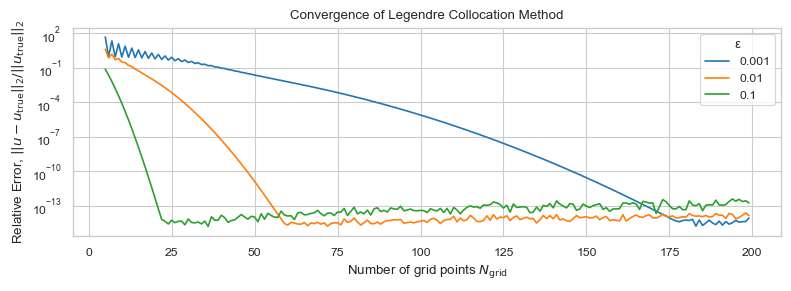

In [23]:
# For report
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))
sns.lineplot(data=df, x="N_grid", y="relative_error", hue="epsilon", palette="tab10")
plt.semilogy()

plt.title("Convergence of Legendre Collocation Method")
plt.xlabel("Number of grid points $N_\\text{grid}$")
plt.ylabel("Relative Error, $||u - u_{\\mathrm{true}}||_2 / ||u_{\\mathrm{true}}||_2$")
sns.move_legend(ax, loc="best", title="ε")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_collocation_convergence.png", dpi=EXPORT_DPI, bbox_inches='tight')

## 2 - Time-dependent Problems
### c) Spectral Method

In [3]:
# Domain
a = -25.0
b = -a
L = b - a

# Problem parameters
c = 1.0  # Wave speed, c > 0
x_0 = 0.0  # Initial position of the soliton
t_0 = 0.0
t_final = 3.0

def travelling_soliton(
    x: npt.NDArray[np.float64], t: float, c: float, x_0: float
) -> npt.NDArray[np.float64]:
    x_prime = x - c * t

    sech_argument = np.sqrt(c) * (x_prime - x_0) / 2.0
    f = 1 / 2 * c * (1 / np.cosh(sech_argument)) ** 2

    return f

In [4]:
# We seek to do stability analysis by linearisation of the problem
N_stability_linears = np.geomspace(4, 2048, num=32, dtype=int)

stability_analysis_data = []
for N_grid in N_stability_linears:
    N = N_grid - 1  # Polynomial degree
    L = b - a  # Domain size

    # Basis functions
    basis_func = partial(trigonometric_polynomial_centered, k=0, N=N_grid, L=L)
    basis_func_grad = partial(trigonometric_polynomial_centered, k=1, N=N_grid, L=L)

    # Set up nodes
    # No last point since we impose periodicity through basis functions
    x = np.linspace(a, b, N_grid, endpoint=False)
    dx = x[1] - x[0]

    # Set up differentiation matrix
    V = construct_vandermonde(x, N_grid, basis_func, dtype=np.complex128)
    V_x = construct_vandermonde(x, N_grid, basis_func_grad, dtype=np.complex128)
    D = np.linalg.solve(V.T, V_x.T).T  # D = V_x * V^{-1}, right solve
    D3 = D @ D @ D

    # Set up initial condition
    u_0 = travelling_soliton(x, t=t_0, c=c, x_0=x_0).astype(np.complex128)

    # In order to do heuristic stability analysis we require a matrix representation of our operator,
    # which in turn requires us to linearize the operator, ideally in a conservative manner
    # Conservative comes from the fact that we pick the maximal value of u_0 as a
    # 'worst case' estimate of the non-linear term.
    u_0_max = np.max(np.abs(u_0))
    L_N_linear = -6 * u_0_max * D - D3

    # Compute eigenvalues for stability analysis
    eigvals_linear_estimate = np.linalg.eigvals(L_N_linear)
    max_eig_magnitude = np.max(np.abs(eigvals_linear_estimate))

    stability_analysis_data.append(
        {
            "N_grid": N_grid,
            "max_eig_magnitude": max_eig_magnitude,
        }
    )

df_stability = pd.DataFrame(stability_analysis_data)

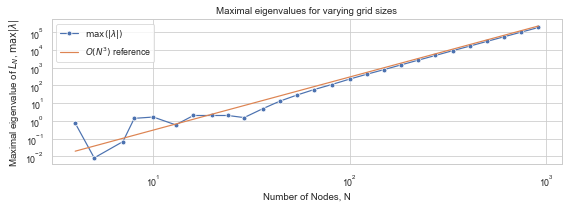

In [9]:
# Plot maximal eigenvalues
fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

sns.lineplot(
    data=df_stability.iloc[:-4],
    x="N_grid",
    y="max_eig_magnitude",
    marker="o",
    label="$\\max(|\\lambda|)$",
)
plt.loglog()
C = 3e-4  # Fit such that reference line is above all points
p = 3  # Fit such that slope matches asymptotic behaviour for large N
plt.plot(
    df_stability["N_grid"][:-4], C * df_stability["N_grid"][:-4] ** p, label="$O(N^3)$ reference"
)
plt.legend()
# Note: Reference should be ABOVE all points for guaranteed stability
plt.ylabel(f"Maximal eigenvalue of $L_N$, $\max|\lambda|$")
plt.xlabel("Number of Nodes, N")
plt.title("Maximal eigenvalues for varying grid sizes")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "2_c_max_eigvals.png", dpi=EXPORT_DPI, bbox_inches='tight')

In [10]:
# See IVP slide 40
s = 2.7853  # eq 2.159 in https://leifh.folk.ntnu.no/teaching/tkt4140/._main025.html#:~:text=By%20substitution%20of%20%CE%BBx,as%20illstrated%20in%20figure%2023.


# Method: RK45
def max_timestep(N: int) -> float:
    """Estimate the maximum stable timestep for an explicit method."""
    return s / (C * N**p)

In [11]:
@dataclass(slots=True, frozen=True)
class SimulationParameters:
    # Simulation Parameters
    N_grid: int  # Number of grid points
    N: int  # Polynomial degree
    dx: float  # Grid spacing

    a: float  # Domain left boundary
    b: float  # Domain right boundary
    L: float  # Domain length

    t_0: float  # Initial time
    t_final: float  # Final time

    t_max_step: float  # Maximum stable timestep, heuristic estimate

    use_jit: bool
    use_orszag_23_rule: bool


@dataclass(slots=True, frozen=True)
class SingleSolitonParameters:
    c: float  # Wave speed
    x_0: float  # Initial position of the soliton


@dataclass(slots=True, frozen=True)
class SimulationResult:
    t: npt.NDArray[np.float64]
    x: npt.NDArray[np.float64]
    u: npt.NDArray[np.float64]
    u_x: npt.NDArray[np.float64]
    u_exact: npt.NDArray[np.float64]

    u_0_numeric: npt.NDArray[np.float64]
    u_0_exact: npt.NDArray[np.float64]
    u_final_numeric: npt.NDArray[np.float64]
    u_final_exact: npt.NDArray[np.float64]

    solve_result: Any

    total_time_wall: float
    total_time_cpu: float

    solve_time_wall: float
    solve_time_cpu: float
    solve_time_per_step_wall: float
    solve_time_per_step_cpu: float

    solve_nfev: int  # Number of function evaluations for solver


@dataclass(slots=True, frozen=True)
class ConservedQuantities:
    masses: npt.NDArray[np.float64]
    momenta: npt.NDArray[np.float64]
    energies: npt.NDArray[np.float64]

    @classmethod
    def from_simulation_result(cls, sim_result: SimulationResult) -> Self:
        u_matrix = sim_result.u
        u_x_matrix = sim_result.u_x
        x = sim_result.x

        masses = np.asarray([trapezoid(u, x) for u in u_matrix.T])
        momenta = np.asarray([trapezoid(u**2, x) for u in u_matrix.T])
        energies = np.asarray(
            [
                np.real(trapezoid(1 / 2 * u_x**2 - u**3, x))
                for u, u_x in zip(u_matrix.T, u_x_matrix.T)
            ]
        )

        return cls(masses=masses, momenta=momenta, energies=energies)


@dataclass(slots=True, frozen=True)
class ErrorMetrics:
    error_L2: float
    relative_error_L2: float
    error_L_inf: float
    relative_error_L_inf: float

    @classmethod
    def from_simulation_result(cls, sim_result: SimulationResult) -> Self:
        u_final_numeric = sim_result.u_final_numeric
        u_final_exact = sim_result.u_final_exact

        error_L2 = np.linalg.norm(u_final_exact - u_final_numeric, ord=2)
        relative_error_L2 = error_L2 / np.linalg.norm(u_final_exact, ord=2)
        error_L_inf = np.linalg.norm(u_final_exact - u_final_numeric, ord=np.inf)
        relative_error_L_inf = error_L_inf / np.linalg.norm(u_final_exact, ord=np.inf)

        return cls(
            error_L2=error_L2,
            relative_error_L2=relative_error_L2,
            error_L_inf=error_L_inf,
            relative_error_L_inf=relative_error_L_inf,
        )


@dataclass(slots=True, frozen=True)
class SingleSolitonResult:
    problem_parameters: SingleSolitonParameters
    simulation_parameters: SimulationParameters
    simulation: SimulationResult
    quantities: ConservedQuantities
    errors: ErrorMetrics


def results_to_df(results: list[Any], strip_keys: bool, sep: str = ".") -> pd.DataFrame:
    sep = "--THIS_WILL_BE_STRIPPED--" if strip_keys else sep

    # We don't want to convert solve_result to dict
    solve_results = [d.simulation.solve_result for d in results]
    df = pd.json_normalize([asdict(d) for d in results], sep=sep)
    df = df.drop(
        columns=df.columns[
            df.columns.str.startswith(f"simulation{sep}solve_result")
        ].tolist()
    )
    df[f"simulation{sep}solve_result"] = solve_results

    if strip_keys:
        # Strip nested keys for easier access
        df.columns = [col.split(sep)[-1] for col in df.columns]

    return df


In [12]:
# Faster FFT implementation, should have N logN scaling
def single_soliton_simulation_fft(
    a: float,
    b: float,
    N_grid: int,
    c: float,
    x_0: float,
    t_0: float,
    t_final: float,
    use_jit: bool = True,
    use_orszag_23_rule: bool = False,
) -> SingleSolitonResult:
    """
    Simulate the KdV equation for a single travelling soliton.
    """
    total_start_time_wall = time.perf_counter()
    total_start_time_cpu = time.process_time()

    N = N_grid - 1  # Polynomial degree
    L = b - a  # Domain size

    x = np.linspace(a, b, N_grid, endpoint=False)

    # Set up initial condition
    u_0 = travelling_soliton(x, t=t_0, c=c, x_0=x_0).astype(np.complex128)

    # Compute wave numbers and differentiation operators
    k = 2 * np.pi * np.fft.fftfreq(N_grid, d=(L / N_grid))  # Wave numbers
    D_hat = 1j * k
    D3_hat = (1j * k) ** 3

    # Set up differential equation operator
    def eval_timestep(
        t: float, u: npt.NDArray[np.complex128]
    ) -> npt.NDArray[np.complex128]:
        u_hat = np.fft.fft(u)

        if use_orszag_23_rule:
            # 2/3 rule is a way to reduce aliasing errors
            # Note that this part of the function will be JIT compiled,
            # so no need to worry about performance here or precomputation outside the function
            # See slides: L6 21-23

            # In default fft frequencies are ordered as zero, positive increasing, negative decreasing
            # As such, the high frequency modes are at center of the array
            # See: https://numpy.org/devdocs/reference/routines.fft.html#implementation-details

            # Pad
            N_size = u_hat.size
            M_size = int(np.ceil(N_size * 3 / 2))  # Pad size
            if N_size % 2 == 0:
                N_pos = N_size // 2 + 1  # Includes 0, positive freqs, Nyquist freq
                N_neg = (
                    N_size // 2 - 1
                )  # Includes negative freqs excluding Nyquist freq
            else:
                N_pos = (N_size + 1) // 2  # Includes 0, positive freqs
                N_neg = N_pos - 1  # Includes negative freqs

            u_hat_padded = np.zeros(M_size, dtype=np.complex128)

            # Add in original coefficients, note new higher frequencies are at center
            u_hat_padded[:N_pos] = u_hat[:N_pos]
            u_hat_padded[M_size - N_neg :] = u_hat[N_size - N_neg :]

            # Differentiate in spectral space
            k_padded = 2 * np.pi * np.fft.fftfreq(M_size, d=(L / M_size))
            D_hat_padded = 1j * k_padded
            u_x_hat_padded = D_hat_padded * u_hat_padded

            # Transform back to physical space
            u_padded = np.fft.ifft(u_hat_padded)
            u_x_padded = np.fft.ifft(u_x_hat_padded)

            # Compute product in physical space
            uu_x_padded = u_padded * u_x_padded

            # Now remove padding in spectral space
            uu_x_hat_padded = np.fft.fft(uu_x_padded)
            uu_x_hat = np.zeros(N_size, dtype=np.complex128)
            uu_x_hat[:N_pos] = uu_x_hat_padded[:N_pos]
            uu_x_hat[N_size - N_neg :] = uu_x_hat_padded[M_size - N_neg :]

            # Fix normalisation gain made by FFT computation
            uu_x_hat *= M_size / N_size  # Should be ≈ 3/2
        else:
            u_x_hat = D_hat * u_hat
            u_x = np.fft.ifft(u_x_hat)
            uu_x = u * u_x
            uu_x_hat = np.fft.fft(uu_x)

        u_xxx_hat = D3_hat * u_hat

        return np.fft.ifft(-6 * uu_x_hat - u_xxx_hat)

    # if use_jit:
    #     eval_timestep = numba.jit(nopython=True, parallel=True)(eval_timestep)

    #     # Compute eval_timestep once to trigger JIT compilation before timing
    #     _ = eval_timestep(t_0, u_0)

    t_max_step = max_timestep(N)
    solve_start_time_wall = time.perf_counter()
    solve_start_time_cpu = time.process_time()
    solve_result = solve_ivp(
        eval_timestep, (t_0, t_final), u_0, method="RK45", max_step=t_max_step
    )
    solve_time_wall = time.perf_counter() - solve_start_time_wall
    solve_time_cpu = time.process_time() - solve_start_time_cpu
    total_time_wall = time.perf_counter() - total_start_time_wall
    total_time_cpu = time.process_time() - total_start_time_cpu

    u_numeric = np.real(solve_result.y)
    u_exact = np.zeros_like(u_numeric)
    for i, t in enumerate(solve_result.t):
        u_exact[:, i] = travelling_soliton(x, t, c=c, x_0=x_0)

    # Calculate u_x for energy calculation
    u_hat = np.fft.fft(u_numeric, axis=0)
    u_x_hat = D_hat[:, None] * u_hat
    u_x = np.fft.ifft(u_x_hat, axis=0).real

    sim_parameters = SimulationParameters(
        N_grid=N_grid,
        N=N,
        dx=dx,
        a=a,
        b=b,
        L=L,
        t_0=t_0,
        t_final=t_final,
        t_max_step=t_max_step,
        use_jit=use_jit,
        use_orszag_23_rule=use_orszag_23_rule,
    )
    problem_parameters = SingleSolitonParameters(
        c=c,
        x_0=x_0,
    )
    sim_result = SimulationResult(
        t=solve_result.t,
        x=x,
        u=u_numeric,
        u_x=u_x,
        u_exact=u_exact,
        u_0_numeric=u_numeric[:, 0],
        u_0_exact=u_exact[:, 0],
        u_final_numeric=u_numeric[:, -1],
        u_final_exact=u_exact[:, -1],
        solve_result=solve_result,
        total_time_wall=total_time_wall,
        total_time_cpu=total_time_cpu,
        solve_time_wall=solve_time_wall,
        solve_time_cpu=solve_time_cpu,
        solve_time_per_step_wall=solve_time_wall / solve_result.nfev,
        solve_time_per_step_cpu=solve_time_cpu / solve_result.nfev,
        solve_nfev=solve_result.nfev,
    )
    conserved_quantities = ConservedQuantities.from_simulation_result(sim_result)
    error_metrics = ErrorMetrics.from_simulation_result(sim_result)

    return SingleSolitonResult(
        problem_parameters=problem_parameters,
        simulation_parameters=sim_parameters,
        simulation=sim_result,
        quantities=conserved_quantities,
        errors=error_metrics,
    )


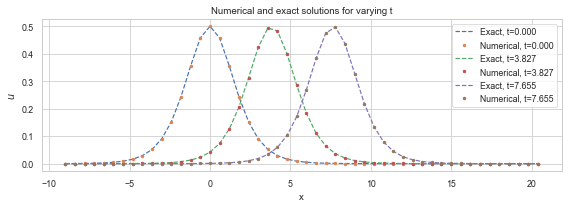

In [35]:
N_grid = 100
t_final = 10

simulation_result = result = single_soliton_simulation_fft(
        a=a,
        b=b,
        N_grid=N_grid,
        c=c,
        x_0=x_0,
        t_0=t_0,
        t_final=t_final,
        use_orszag_23_rule=False,
        use_jit=False,
    ).simulation


# Get color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))
for t, u, uex in zip(simulation_result.t[::400], simulation_result.u.T[::400], simulation_result.u_exact.T[::400]):
    plt.plot(simulation_result.x[35:-15], uex[35:-15], "--", label=f"Exact, t={t:.3f}")
    plt.plot(simulation_result.x[35:-15], u[35:-15], ".", label=f"Numerical, t={t:.3f}")


plt.legend()
plt.ylabel(r"$u$")
plt.xlabel("x")
plt.title("Numerical and exact solutions for varying t")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "2_c_solutions.png", dpi=EXPORT_DPI, bbox_inches='tight')

## d) - Testing the solver

In [8]:
# Simulation parameters
t_0 = 0.0
t_final = 3.0

a = -25.0
b = -a

# Problem parameters
cs = [0.25, 0.5, 1.0]
x_0 = 0.0  # Initial position of the soliton


# TODO: Heuristic for minimum discretisation, see FB conversation
N_GRID_MIN = 28
N_GRID_FINE_THRESHOLD = 20
N_GRID_MAX = 256
N_GRID_NUM = 20

# N_grids_fine = np.arange(N_GRID_MIN, N_GRID_FINE_THRESHOLD + 1, dtype=int)
# N_grids_coarse = np.linspace(
#     N_GRID_FINE_THRESHOLD + 1, N_GRID_MAX, num=N_GRID_NUM - len(N_grids_fine), dtype=int
# )
# N_grids = np.concatenate([N_grids_fine, N_grids_coarse])
N_grids = np.linspace(N_GRID_MIN, N_GRID_MAX, num=N_GRID_NUM, dtype=int)


data = []
for N_grid, c in itertools.product(N_grids, cs):
    print(f"Running simulation for N_grid={N_grid}")

    result = single_soliton_simulation_fft(
        a=a, 
        b=b, 
        N_grid=N_grid, 
        c=c, 
        x_0=x_0, 
        t_0=t_0, 
        t_final=t_final, 
        use_orszag_23_rule=False,
        use_jit=False
    )
    data.append(result)

data_2d = data.copy()
df = results_to_df(data_2d, strip_keys=True)
df_2d = df.copy()

Running simulation for N_grid=28


NameError: name 'C' is not defined

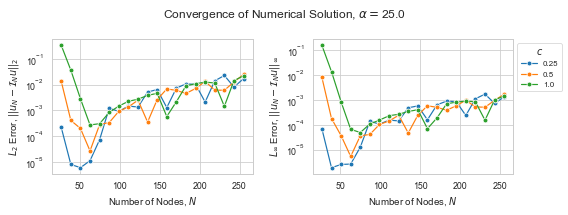

In [64]:
fig, (ax_L2, ax_L_inf) = plt.subplots(1, 2, figsize=(PAPER_WIDTH_IN, 3))
sns.lineplot(df_2d, ax=ax_L_inf, x="N", y="error_L_inf", hue="c", marker="o", palette="tab10")
sns.lineplot(df_2d, ax=ax_L2, x="N", y="error_L2", hue="c", marker="o", palette="tab10")

ax_L2.semilogy()
ax_L_inf.semilogy()

fig.suptitle(fr"Convergence of Numerical Solution, $\alpha=${b}", y=0.98, fontsize=12)

ax_L2.set_ylabel(r"$L_2$ Error, $||u_N - \mathcal{I}_N u||_2$")
ax_L_inf.set_ylabel(r"$L_∞$ Error, $||u_N - \mathcal{I}_N u||_∞$")
ax_L2.set_xlabel("Number of Nodes, $N$")
ax_L_inf.set_xlabel("Number of Nodes, $N$")

ax_L2.legend().remove()
ax_L_inf.legend(title="$c$", loc="upper left", fontsize=8, bbox_to_anchor=(1.0, 1.0))

fig.tight_layout()
fig.subplots_adjust(wspace=0.3)

fig.savefig(OUTPUT_DIR / "2_d_error_alpha25.png", dpi=EXPORT_DPI, bbox_inches="tight")

In [13]:
# Simulation parameters
t_0 = 0.0
t_final = 3.0

a = -50.0
b = -a

# Problem parameters
cs = [0.25, 0.5, 1.0]
x_0 = 0.0  # Initial position of the soliton


# TODO: Heuristic for minimum discretisation, see FB conversation
N_GRID_MIN = 28
N_GRID_FINE_THRESHOLD = 20
N_GRID_MAX = 475
N_GRID_NUM = 20

# N_grids_fine = np.arange(N_GRID_MIN, N_GRID_FINE_THRESHOLD + 1, dtype=int)
# N_grids_coarse = np.linspace(
#     N_GRID_FINE_THRESHOLD + 1, N_GRID_MAX, num=N_GRID_NUM - len(N_grids_fine), dtype=int
# )
# N_grids = np.concatenate([N_grids_fine, N_grids_coarse])
N_grids = np.linspace(N_GRID_MIN, N_GRID_MAX, num=N_GRID_NUM, dtype=int)


data = []
for N_grid, c in itertools.product(N_grids, cs):
    print(f"Running simulation for N_grid={N_grid}")

    result = single_soliton_simulation_fft(
        a=a, 
        b=b, 
        N_grid=N_grid, 
        c=c, 
        x_0=x_0, 
        t_0=t_0, 
        t_final=t_final, 
        use_orszag_23_rule=False,
        use_jit=False
    )
    data.append(result)

data_2d = data.copy()
df = results_to_df(data_2d, strip_keys=True)
df_2d = df.copy()

Running simulation for N_grid=28
Running simulation for N_grid=28
Running simulation for N_grid=28
Running simulation for N_grid=51
Running simulation for N_grid=51
Running simulation for N_grid=51
Running simulation for N_grid=75
Running simulation for N_grid=75
Running simulation for N_grid=75
Running simulation for N_grid=98
Running simulation for N_grid=98
Running simulation for N_grid=98
Running simulation for N_grid=122
Running simulation for N_grid=122
Running simulation for N_grid=122
Running simulation for N_grid=145
Running simulation for N_grid=145
Running simulation for N_grid=145
Running simulation for N_grid=169
Running simulation for N_grid=169
Running simulation for N_grid=169
Running simulation for N_grid=192
Running simulation for N_grid=192
Running simulation for N_grid=192
Running simulation for N_grid=216
Running simulation for N_grid=216
Running simulation for N_grid=216
Running simulation for N_grid=239
Running simulation for N_grid=239
Running simulation for N_g

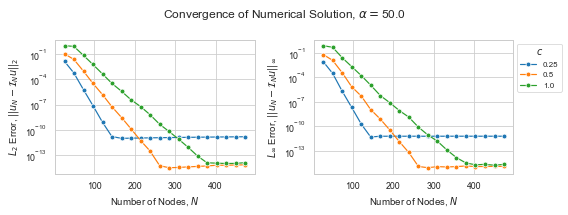

In [14]:
fig, (ax_L2, ax_L_inf) = plt.subplots(1, 2, figsize=(PAPER_WIDTH_IN, 3))
sns.lineplot(df_2d, ax=ax_L_inf, x="N", y="error_L_inf", hue="c", marker="o", palette="tab10")
sns.lineplot(df_2d, ax=ax_L2, x="N", y="error_L2", hue="c", marker="o", palette="tab10")

ax_L2.semilogy()
ax_L_inf.semilogy()

fig.suptitle(fr"Convergence of Numerical Solution, $\alpha=${b}", y=0.98, fontsize=12)

ax_L2.set_ylabel(r"$L_2$ Error, $||u_N - \mathcal{I}_N u||_2$")
ax_L_inf.set_ylabel(r"$L_∞$ Error, $||u_N - \mathcal{I}_N u||_∞$")
ax_L2.set_xlabel("Number of Nodes, $N$")
ax_L_inf.set_xlabel("Number of Nodes, $N$")

ax_L2.legend().remove()
ax_L_inf.legend(title="$c$", loc="upper left", fontsize=8, bbox_to_anchor=(1.0, 1.0))

fig.tight_layout()
fig.subplots_adjust(wspace=0.3)

fig.savefig(OUTPUT_DIR / "2_d_error_alpha50.png", dpi=EXPORT_DPI, bbox_inches="tight")

In [18]:
# Simulation parameters
t_0 = 0.0
t_final = 3.0

a = -50.0
b = -a

# Problem parameters
cs = [0.25, 0.5, 1.0]
x_0 = 0.0  # Initial position of the soliton


# Assume you already have results for multiple c values, e.g.:
results = {}  # dictionary to store results

Ngrid = N_GRID_MAX

for c_val in cs:
    print(f"Running simulation for c = {c_val}")

    result = single_soliton_simulation_fft(
        a=a,
        b=b,
        N_grid=N_grid,
        c=c_val,
        x_0=x_0,
        t_0=t_0,
        t_final=t_final,
        use_orszag_23_rule=False,
        use_jit=False,
    ).simulation

    results[c_val] = result  # store using c as key


Running simulation for c = 0.25
Running simulation for c = 0.5
Running simulation for c = 1.0


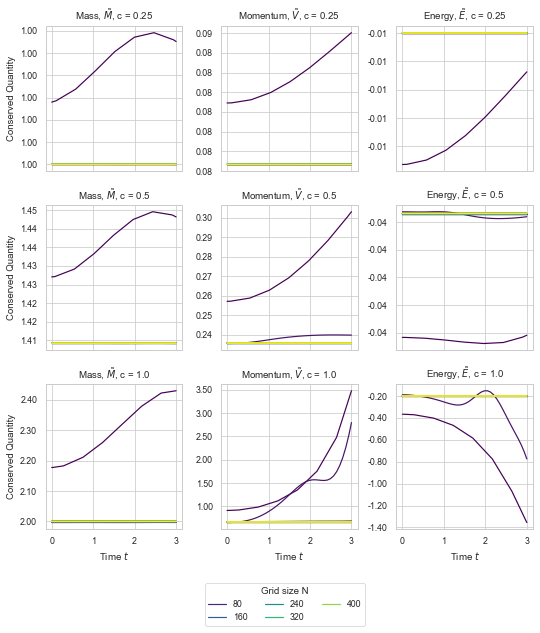

In [48]:
df_flat = df.explode(
    [
        "t",
        "masses",
        "momenta",
        "energies",
    ]
)

df_flat_melt_conserved = df_flat.melt(
    id_vars=["t", "N", "c"],
    value_vars=[
        "masses",
        "momenta",
        "energies",
    ],
)



g = sns.relplot(
    data=df_flat_melt_conserved,
    x="t",
    y="value",
    hue="N",
    col="variable",
    row="c",
    kind="line",
    estimator=None,  
    units=None,       
    facet_kws={"sharey": False, "sharex": True},
    palette="viridis",
)

# Optional: adjust labels and spacing
g.set_axis_labels("Time $t$", "Conserved Quantity")
g.figure.set_size_inches(PAPER_WIDTH_IN, PAPER_WIDTH_IN)


# --- Format y-ticks to 2 decimals on all axes ---
for ax_row in g.axes:
    for ax in ax_row:
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

        for spine in ax.spines.values():
            spine.set_visible(True)

# --- Customize facet titles on all axes ---
custom_titles = {
    "masses": r"Mass, $\tilde{M}$",
    "momenta": r"Momentum, $\tilde{V}$",
    "energies": r"Energy, $\tilde{E}$"
}

for (row_val, col_val), ax in g.axes_dict.items():
    if col_val in custom_titles:
        ax.set_title(f"{custom_titles[col_val]}, c = {row_val}")

handles, labels = g.axes[0, 0].get_legend_handles_labels()
g._legend.remove()
g.figure.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=3,
    title="Grid size N",
)
g.figure.subplots_adjust(bottom=0.1)

# Optional: adjust layout and spacing
g.tight_layout()


g.savefig(OUTPUT_DIR / "2_d_conservation.png", dpi=EXPORT_DPI, bbox_inches="tight")